In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

import random
import empyrical

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['figure.figsize'] = (8, 6)  

def report(tradelist,initial_capital,type_analisy,Benchmark):
    
    %matplotlib inline
    import quantstats as qs
    qs.extend_pandas()

    tradelist = tradelist.fillna(0)
    tradelist = tradelist[tradelist!=0]
    tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
    tradelist = tradelist.cumsum()

    if type_analisy == 0:
        qs.plots.snapshot(tradelist)

    if type_analisy == 1:    
        if len(Benchmark)==0:
            qs.reports.basic(tradelist)
        else:
            qs.reports.basic(tradelist,Benchmark)

    if type_analisy == 2:    
        if len(Benchmark)==0:
            qs.reports.full(tradelist)
        else:
            qs.reports.full(tradelist,Benchmark)

In [2]:
data  = pd.read_csv("big_data.csv" , header=[0, 1], index_col=0)
data.index = pd.to_datetime(data.index)
data.tail()

AUDCAD                                            AUDCHF  \
               open     high      low    close bigpointvalue     open   
time                                                                    
2023-11-27  0.89598  0.90138  0.89582  0.89947        111609  0.57954   
2023-11-28  0.89923  0.90417  0.89750  0.90243        111206  0.58036   
2023-11-29  0.90183  0.90425  0.89771  0.89918        110885  0.58354   
2023-11-30  0.89897  0.90261  0.89404  0.89552        111238  0.57725   
2023-12-01  0.89573  0.90153  0.89365  0.90077        111640  0.57807   

                                                     ...   USDCHF           \
               high      low    close bigpointvalue  ...     open     high   
time                                                 ...                     
2023-11-27  0.58208  0.57944  0.58157        172550  ...  0.88152  0.88280   
2023-11-28  0.58407  0.58036  0.58375        172306  ...  0.88025  0.88187   
2023-11-29  0.58496  0.57767  0.57824        171367  ...  0.87771  0.87841   
2023-11-30  0.58034  0.57580  0.57804        173235  ...  0.87379  0.87707   
2023-12-01  0.58076  0.57668  0.58003        172989  ...  0.87484  0.87684   

                                             USDJPY                    \
                low    close bigpointvalue     open     high      low   
time                                                                    
2023-11-27  0.87936  0.88029        113440  149.412  149.674  148.549   
2023-11-28  0.87612  0.87801        113604  148.670  148.828  147.323   
2023-11-29  0.87201  0.87384        113932  147.479  147.908  146.670   
2023-11-30  0.86847  0.87517        114443  147.234  148.510  146.841   
2023-12-01  0.86791  0.86900        114306  148.174  148.347  146.661   

                                   
              close bigpointvalue  
time                               
2023-11-27  148.681           669  
2023-11-28  147.465           672  
2023-11-29  147.232           678  
2023-11-30  148.224           679  
2023-12-01  146.804           674  

[5 rows x 140 columns]

In [3]:
asset_list = data.columns.get_level_values(0).unique().tolist()
asset_list

['AUDCAD',
 'AUDCHF',
 'AUDJPY',
 'AUDNZD',
 'AUDUSD',
 'CADCHF',
 'CADJPY',
 'CHFJPY',
 'EURAUD',
 'EURCAD',
 'EURCHF',
 'EURGBP',
 'EURJPY',
 'EURNZD',
 'EURUSD',
 'GBPAUD',
 'GBPCAD',
 'GBPCHF',
 'GBPJPY',
 'GBPNZD',
 'GBPUSD',
 'NZDCAD',
 'NZDCHF',
 'NZDJPY',
 'NZDUSD',
 'USDCAD',
 'USDCHF',
 'USDJPY']

  0%|          | 0/28 [00:00<?, ?it/s]

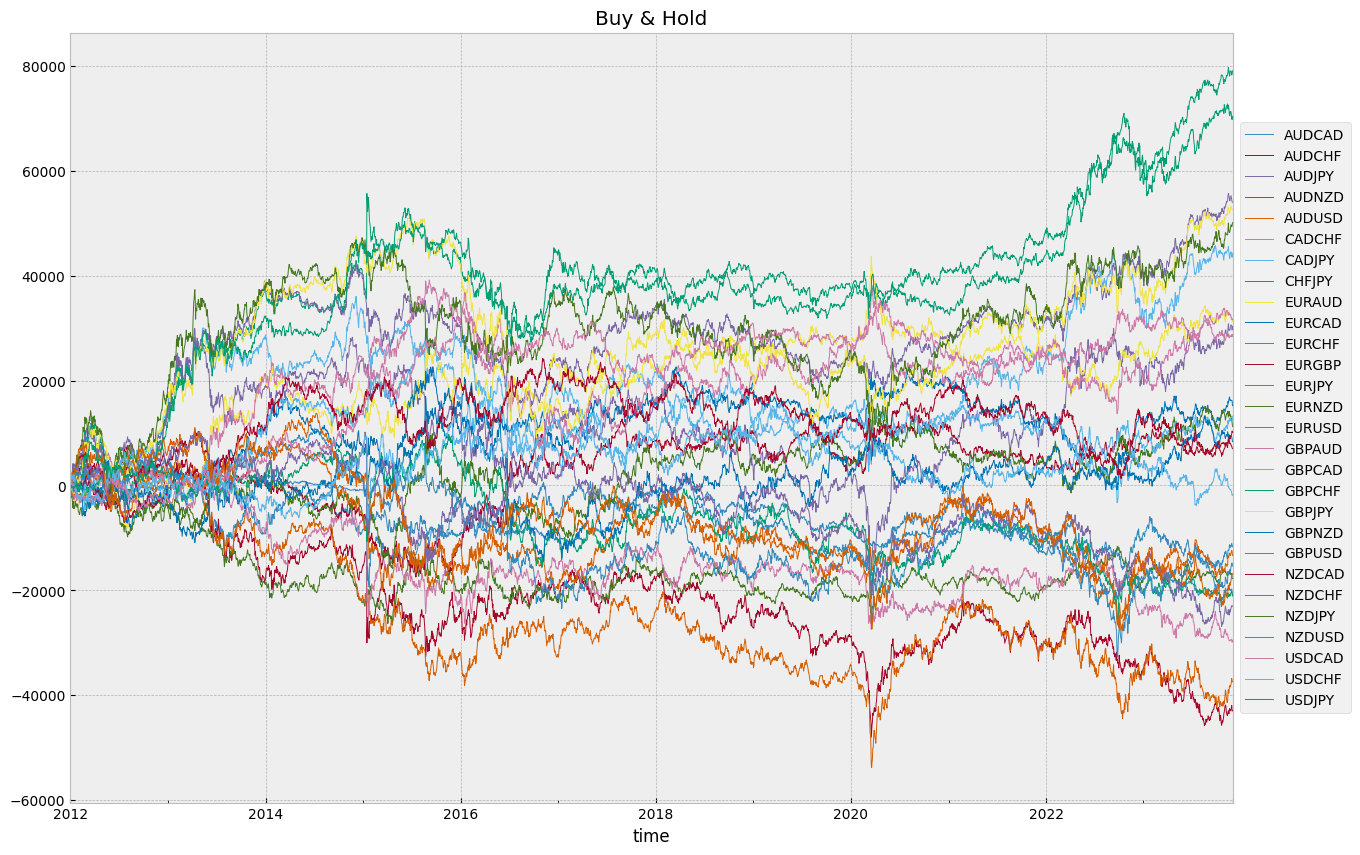

In [4]:
pnl = pd.DataFrame()

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    buy_and_hold = ((df.open.shift(-1)-df.open)*df.bigpointvalue).to_frame(asset)
    pnl = pd.concat([pnl,buy_and_hold],axis=1)
    
pnl=pnl.fillna(0)
pnl.cumsum().plot(figsize=(15,10) ,title="Buy & Hold")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [49]:
def preprocess(dataset):
    
    dataset_perc = dataset.apply(lambda x: np.log(x)).pct_change()
    
    LPERC = 0.01
    HPERC = 0.99

    for column in dataset_perc.columns:
        lower_perc = dataset_perc[column].quantile(LPERC)
        higher_perc = dataset_perc[column].quantile(HPERC)
        dataset_perc[column] = dataset_perc[column].clip(lower_perc,higher_perc)
        
    dataset_perc["avgclose5"] = dataset_perc.close.rolling(5).mean()
    dataset_perc["avgclose20"] = dataset_perc.close.rolling(20).mean()
    dataset_perc["avgclose50"] = dataset_perc.close.rolling(50).mean()
    dataset_perc["avgclose100"] = dataset_perc.close.rolling(100).mean()
    dataset_perc["avgclose200"] = dataset_perc.close.rolling(200).mean()

    dataset_perc["stdclose5"] = dataset_perc.close.rolling(5).std()
    dataset_perc["stdclose20"] = dataset_perc.close.rolling(20).std()
    dataset_perc["stdclose50"] = dataset_perc.close.rolling(50).std()
    dataset_perc["stdclose100"] = dataset_perc.close.rolling(100).std()
    dataset_perc["stdclose200"] = dataset_perc.close.rolling(200).std()

    dataset_perc["max5"] = dataset_perc.high.rolling(5).max()
    dataset_perc["max20"] = dataset_perc.high.rolling(20).max()
    dataset_perc["max50"] = dataset_perc.high.rolling(50).max()
    dataset_perc["max100"] = dataset_perc.high.rolling(100).max()
    dataset_perc["max200"] = dataset_perc.high.rolling(200).max()

    dataset_perc["min5"] = dataset_perc.low.rolling(5).min()
    dataset_perc["min20"] = dataset_perc.low.rolling(20).min()
    dataset_perc["min50"] = dataset_perc.low.rolling(50).min()
    dataset_perc["min100"] = dataset_perc.low.rolling(100).min()
    dataset_perc["min200"] = dataset_perc.low.rolling(200).min()
        
    dataset_perc["sharpe_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.sharpe_ratio)    
    dataset_perc["sharpe_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.sharpe_ratio)
    
    dataset_perc["omega_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.omega_ratio)    
    dataset_perc["omega_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.omega_ratio)
    
    dataset_perc["sortino_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.sortino_ratio)    
    dataset_perc["sortino_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.sortino_ratio)
    
                
    df_temp = pd.DataFrame()
    shift_range = 5
    
    ls_t = ["avgclose5","avgclose20","avgclose50","avgclose100","avgclose200"]   
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
 
                
    ls_t = ["stdclose5","stdclose20","stdclose50","stdclose100","stdclose200"]   
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
               
    ls_t = ["max5","max20","max50","max100","max200"]   
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)
 
    ls_t = ["min5","min20","min50","min100","min200"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)

    ls_t = ["sharpe_ratio5","sharpe_ratio20","sharpe_ratio50","sharpe_ratio100","sharpe_ratio200"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                    

                        
    ls_t = ["sortino_ratio5","sortino_ratio20","sortino_ratio50","sortino_ratio100","sortino_ratio200"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                    

    ls_t = ["omega_ratio5","omega_ratio20","omega_ratio50","omega_ratio100","omega_ratio200"]  
    for I in ls_t:
        for O in ls_t:
            if I != O :
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)                    
                                                                        
    return df_temp

In [50]:
array_list=[]

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    
    df_t = preprocess(df)
    
    df_t = df_t[df_t.index.isin(pnl.index)]
    
    array_list.append(df_t.T.to_numpy())
    
array_pnl = pnl.T.to_numpy()

array_list = np.stack(array_list)

array_rules = df_t.columns.to_numpy()

  0%|          | 0/28 [00:00<?, ?it/s]

In [62]:
def create_dna(individual, array_list):
    
    dna = array_list[:, individual[0], :]

    for ind in individual[1:]:
        dna = np.bitwise_and(dna, array_list[:, ind, :])

    return dna

def get_dna(individual, array_rules):
    
    dna = array_rules[individual[0]]

    for ind in individual[1:]:
        dna = dna + " & " + array_rules[ind]

    return dna

def my_instability(array,pct):
    
    n_element = int(pct * len(array))

    array_ = array.copy()

    indici_ = np.random.choice(len(array), n_element, replace=False)

    array_[indici_] = 0

    return array_

def fitness_function(individual):

    res = create_dna(individual , array_list)
    res = res * array_pnl
    res = res.sum(axis=0)
    res = res[res!=0]
    
    if INSTABILITY != 0 :
        
        res = my_instability(res,INSTABILITY)

    rank = eval("empyrical."+FITNESS+"(res)") 
 
    if (np.isnan(rank)) | (len(res)<MIN_OPERATIONS):
        return -999999,
    else:
        return rank,
    
def backtest(individual):
    
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['lines.linewidth'] = 0.7
    plt.rcParams['figure.figsize'] = (8, 6)  
    
    res = create_dna(individual , array_list)
    res = res * array_pnl

    results = pd.DataFrame(res).T
    results.columns = pnl.columns
    results.index = pnl.index
    
    results.cumsum().plot(title="Portfolio Assets")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    results.sum(axis=1).cumsum().plot(label="Genetic Evolution")
    plt.legend(loc="upper left")
    pnl.sum(axis=1).cumsum().plot(label="Buy & Hold" ,secondary_y=True ,color="grey",linewidth=0.2)
    plt.legend(loc="lower right")
    plt.show()
    
    return results

In [76]:
def GAM (DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , TOURNSIZE ,
         MIN_OPERATIONS , FITNESS , INSTABILITY ):

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", fitness_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(array_rules)- 1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
    toolbox.register("individual", creator.Individual, [random.randint(0, len(array_rules)-1) for _ in range(DNA_SIZE)])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    population = toolbox.population(n=POPULATION_SIZE)

    halloffame = tools.HallOfFame(HALL_OF_FAME)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(population, toolbox, 
                                              cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB, 
                                              ngen=NUM_GENERATIONS, stats=stats, 
                                              halloffame=halloffame, verbose=True)

    best_solution = halloffame[0]
    print("")
    print(colored("Best Solution:", 'red'))
    print(colored(get_dna(best_solution,array_rules), 'green'))
    
    return best_solution

In [77]:
from deap import base, creator, tools, algorithms

DNA_SIZE = 3

CROSS_DNA_RATIO = 0.7

MUTATION_PROB = 0.3

POPULATION_SIZE = 500

NUM_GENERATIONS = 20

HALL_OF_FAME = 10

TOURNSIZE = 10

MIN_OPERATIONS = 500

FITNESS = "omega_ratio"  
# "sharpe_ratio" 
# "omega_ratio" 
# "sortino_ratio"

INSTABILITY = 0.1

best_solution =  GAM (DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , 
                      TOURNSIZE , MIN_OPERATIONS , FITNESS , INSTABILITY )


gen	nevals	avg    	min    	max    
0  	500   	1.06248	0.99706	1.14711
1  	391   	-31998.9	-999999	1.24598
2  	390   	-11998.9	-999999	1.2331 
3  	395   	-31998.9	-999999	1.31265
4  	390   	-15998.8	-999999	1.31763
5  	413   	-15998.8	-999999	1.31763
6  	408   	-23998.8	-999999	1.36355
7  	373   	-19998.8	-999999	1.37211
8  	391   	-25998.7	-999999	1.41711
9  	393   	-19998.7	-999999	1.41711
10 	394   	-25998.7	-999999	1.41964
11 	412   	-21998.7	-999999	1.41964
12 	401   	-19998.7	-999999	1.41964
13 	409   	-17998.7	-999999	1.41711
14 	396   	-33998.7	-999999	1.41711
15 	383   	-21998.7	-999999	1.41711
16 	387   	-15998.7	-999999	1.41711
17 	377   	-27998.7	-999999	1.41711
18 	394   	-25998.7	-999999	1.41855
19 	413   	-29998.7	-999999	1.41855
20 	399   	-19998.7	-999999	1.42215

Best Solution:
stdclose200.shift(2)>stdclose50.shift(2) & stdclose5.shift(4)>stdclose50.shift(1) & sharpe_ratio50.shift(1)>sharpe_ratio100.shift(2)


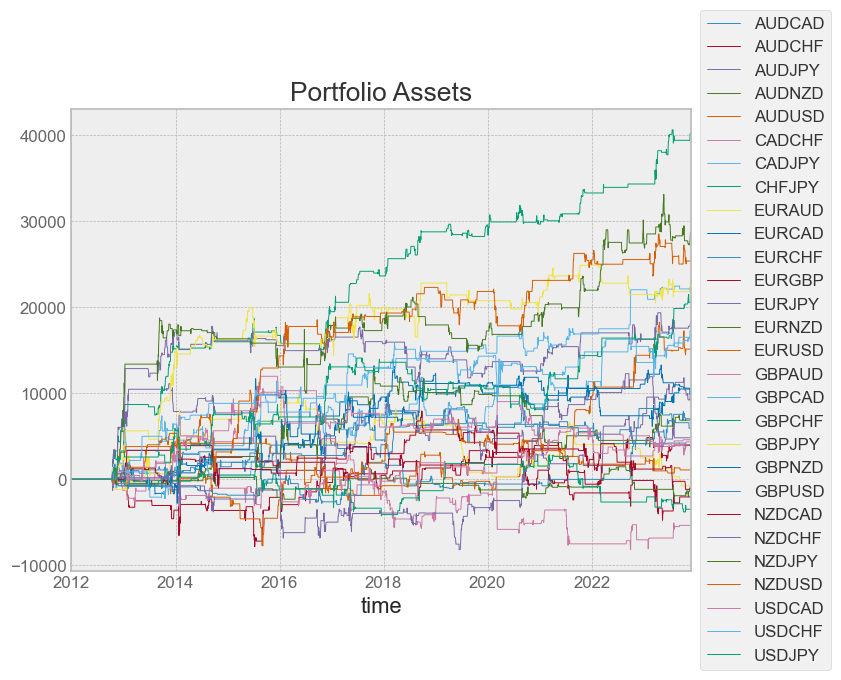

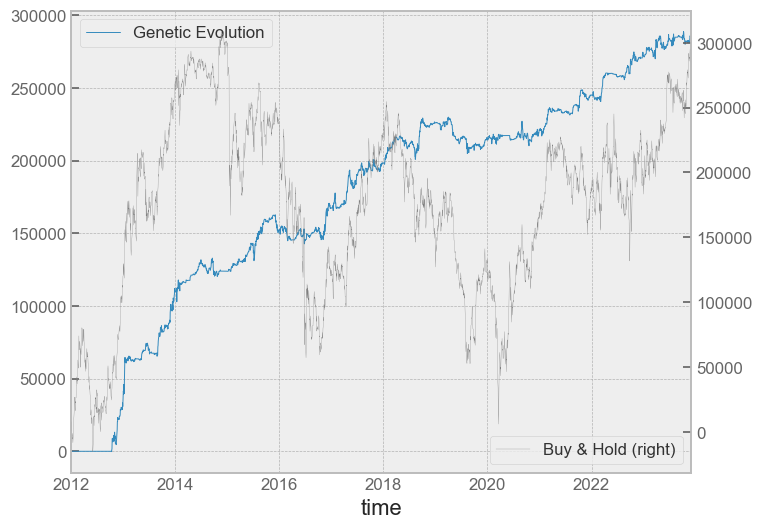

In [78]:
tradelist = backtest(best_solution)

                           Strategy
-------------------------  ----------
Start Period               2012-10-10
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          284.96%
CAGR﹪                     8.71%

Sharpe                     1.53
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.47
Sortino                    2.66
Smart Sortino              2.57
Sortino/√2                 1.88
Smart Sortino/√2           1.82
Omega                      1.42

Max Drawdown               -7.61%
Longest DD Days            694
Volatility (ann.)          9.93%
Calmar                     1.14
Skew                       2.24
Kurtosis                   26.81

Expected Daily %           0.06%
Expected Monthly %         1.02%
Expected Yearly %          11.89%
Kelly Criterion            16.25%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.97%
Expected Shortfall (cVaR)  -0.97%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-12-07,2016-06-27,2016-11-23,353,-7.612805,-6.816446
2,2019-04-04,2019-08-14,2021-02-25,694,-7.578353,-6.722805
3,2012-11-02,2012-11-13,2012-11-19,18,-7.561840,-6.984182
4,2014-09-19,2014-10-23,2015-05-07,231,-5.408211,-5.321405
5,2013-06-21,2013-08-27,2013-09-03,75,-5.138856,-4.650019


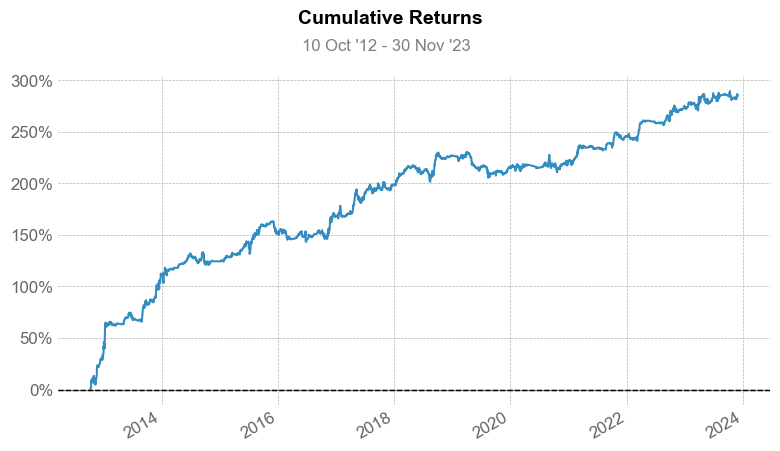

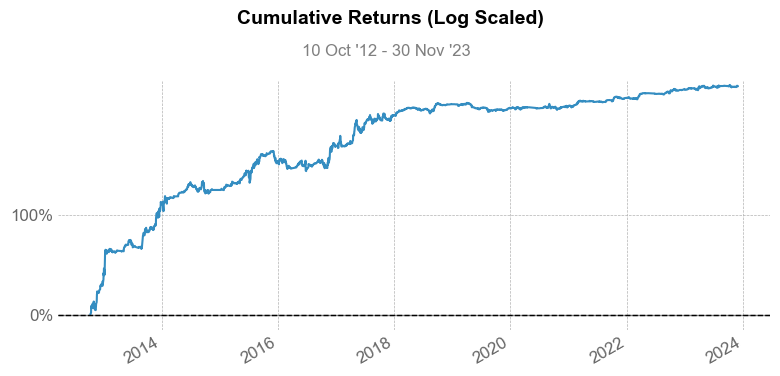

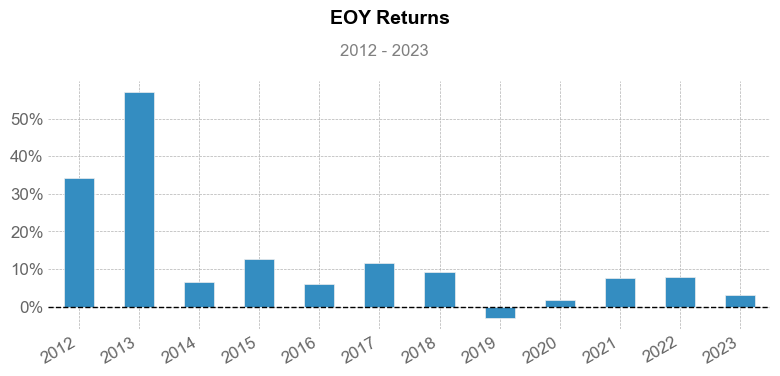

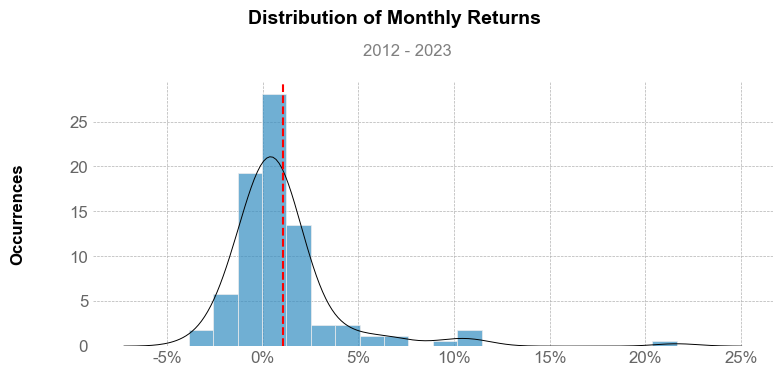

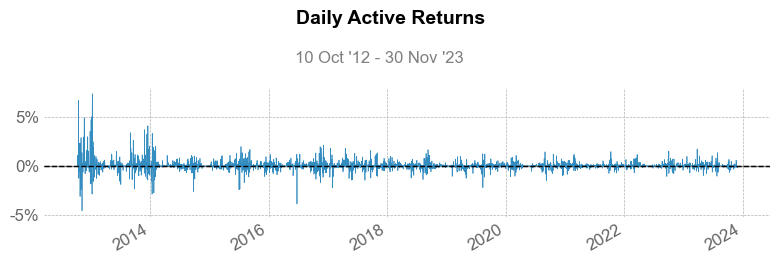

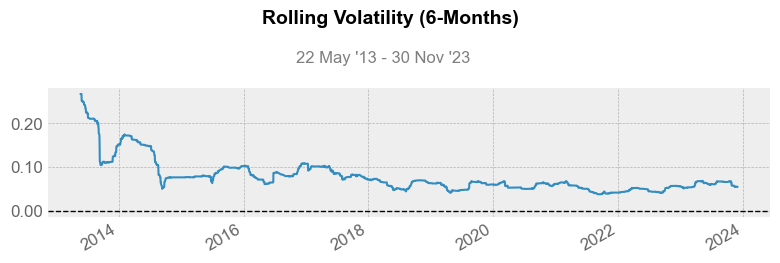

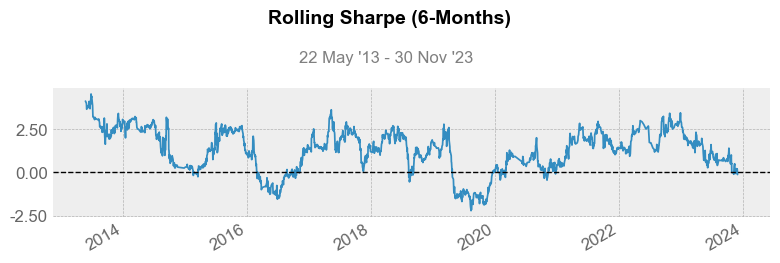

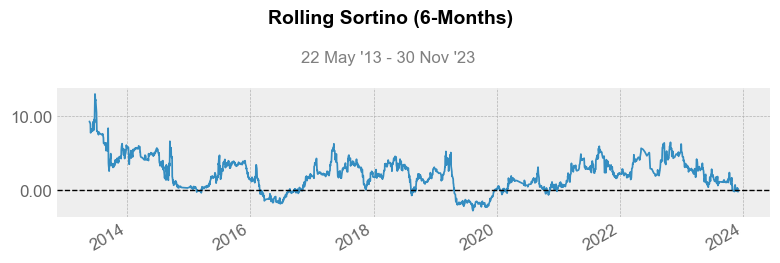

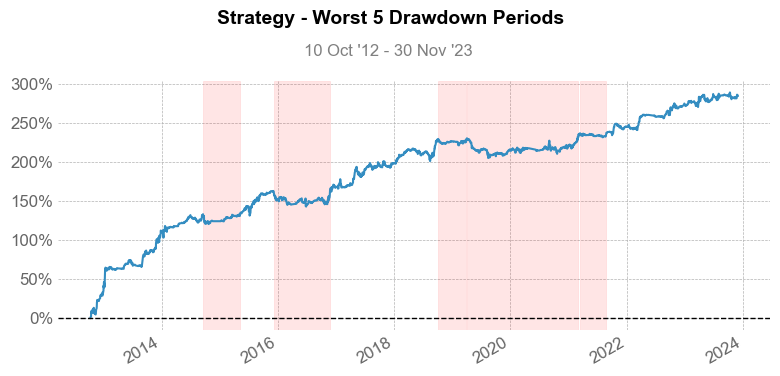

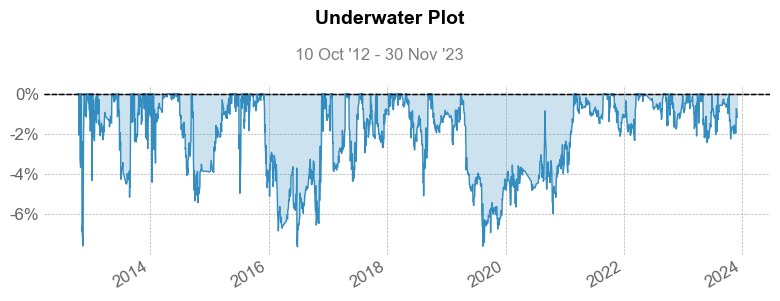

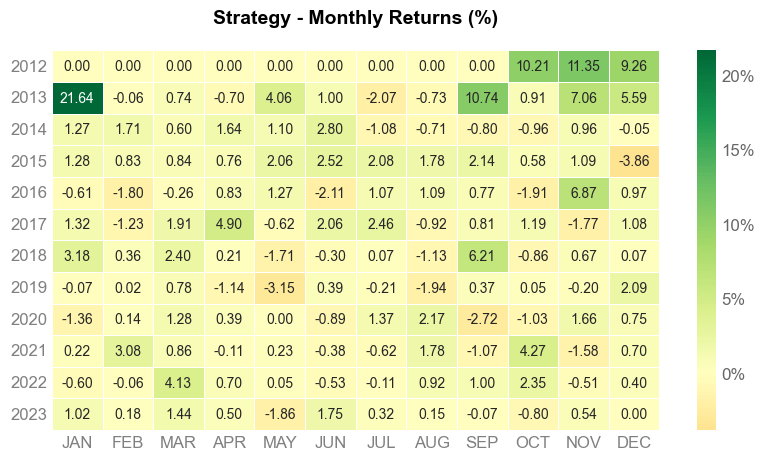

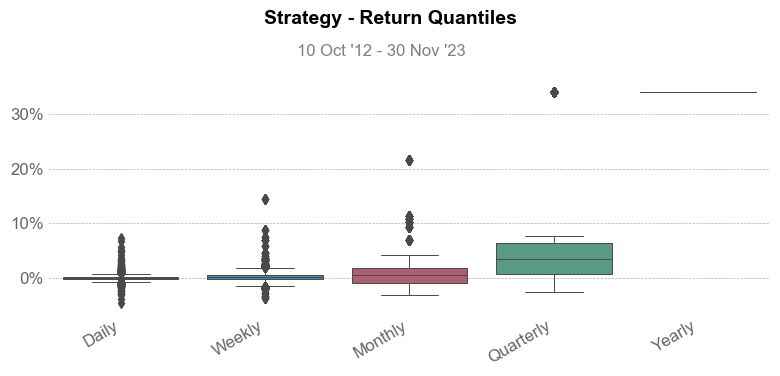

In [79]:
report(tradelist.sum(axis=1) ,100000 ,2,"")